<a href="https://colab.research.google.com/github/Leo1711/cs50web/blob/main/learning_clustering_mall_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mall Customer Segmentation: Learning Project II

This is a learning project based on a dataset that has often been used to do clustering. 
The dataset is from [Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/code)


Infos about the dataset

Age, income and gender and customer ID are straightforward - the spending score is just a score from 1-100 that ficticiosly and metaphorically states the spending willingness based on past data that has been aggregated.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/content/Mall_Customers.csv")

## EDA

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


All the statistical information seem normal, considering the fact, that the dtype is also a float and not a object, the dataset seems clean - no random '?' or something similar should be in it. 

In [14]:
missing_values = df.isnull().sum()
print(missing_values)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [15]:
df.duplicated().sum()

0

### Univariate Analysis

In [20]:
df['CustomerID'].dtype

dtype('int64')

In [21]:
df['CustomerID'].astype(int)

0        1
1        2
2        3
3        4
4        5
      ... 
195    196
196    197
197    198
198    199
199    200
Name: CustomerID, Length: 200, dtype: int64

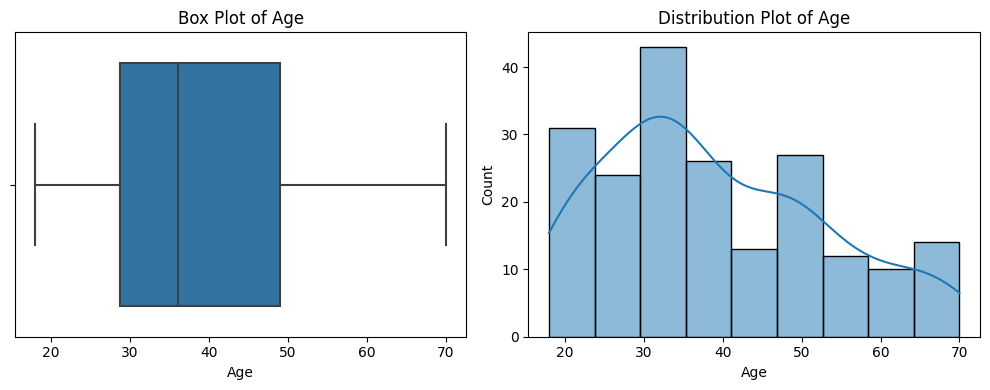

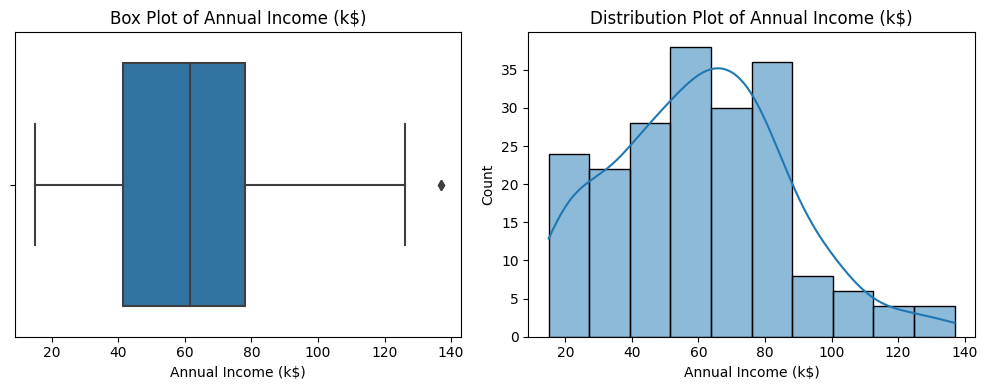

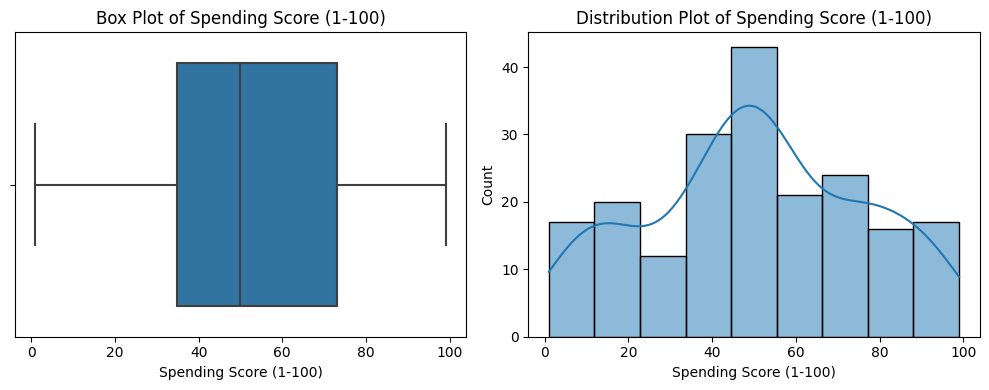

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_visualize = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for column in columns_to_visualize:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Box plot
    sns.boxplot(x=df[column], ax=axes[0])
    axes[0].set_title(f"Box Plot of {column}")

    # Distribution plot 
    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f"Distribution Plot of {column}")

    plt.tight_layout()
    plt.show()

There are mostly 30-50 year old people in the dataset with quite a bit of distributed data points on the older side. 

The same structure applies to income with a statistically true median salary above $60'000. 

Almost the opposite structure is true for the spending score. This is more of a normal distribution.

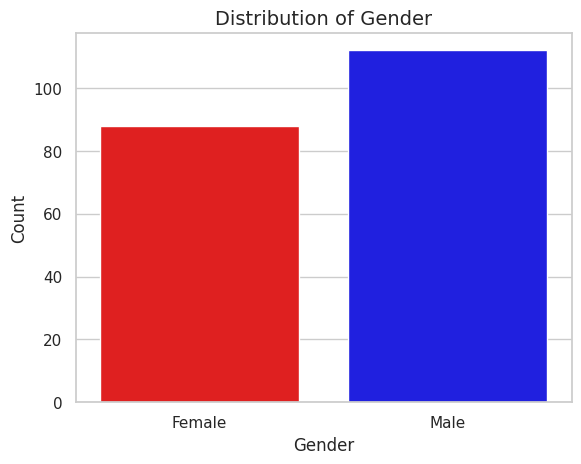

In [30]:
custom_palette = ["red", "blue"]

sns.set(style="whitegrid", palette=custom_palette)
ax = sns.countplot(data=df, x='Gender')

plt.title('Distribution of Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

ax.set_xticklabels(['Female', 'Male'], fontsize=11)

plt.show()

### Bivariate Analysis

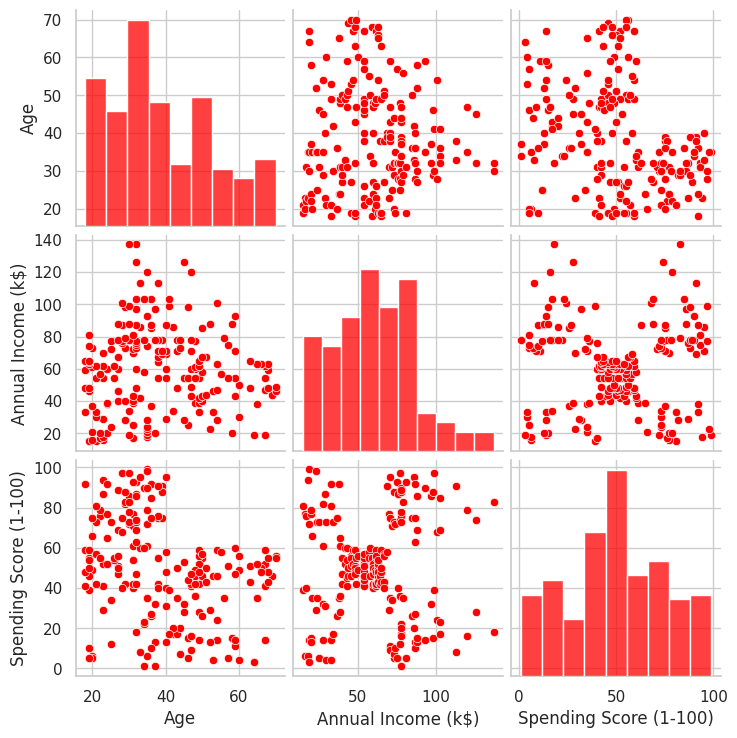

In [37]:
columns_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
sns.pairplot(df[columns_to_plot])

plt.show()

Something very peculiar to note is the cluster of 40-60 years olds and their annual income at around the $50'000.

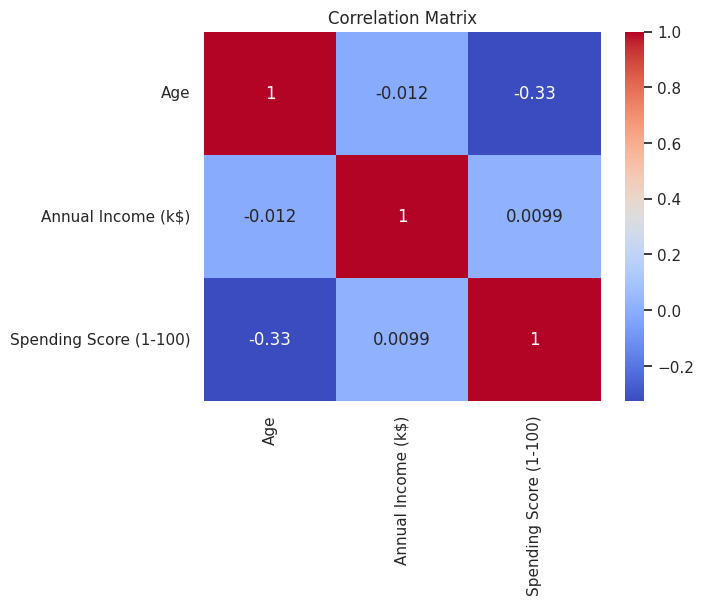

In [38]:
columns_for_corr = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
corr_matrix = df[columns_for_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Spending score seems to be somewhat negatively correlated with Age, which might make sense considering the fact that younger people tend to buy more in general.

## Data Pre-Processing for Clustering

In [39]:
# customer ID has no value for clustering and may even be misleasing, so drop it
df1 = df.copy()
df1 = df1.drop('CustomerID', axis=1)

In [40]:
# sanity check
df1.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [47]:
df1.rename(columns={'Annual Income (k$)': 'Annual Income ($)'}, inplace=True)
df1['Annual Income ($)'] = df1['Annual Income ($)'] * 1000
df1.head()

,Gender,Age,Annual Income ($),Spending Score (1-100)
0,Male,19,15000000000,39
1,Male,21,15000000000,81
2,Female,20,16000000000,6
3,Female,23,16000000000,77
4,Female,31,17000000000,40


In [49]:
df1['Annual Income ($)'] = df1['Annual Income ($)'] / 1000
df1.head()

,Gender,Age,Annual Income ($),Spending Score (1-100)
0,Male,19,15000.0,39
1,Male,21,15000.0,81
2,Female,20,16000.0,6
3,Female,23,16000.0,77
4,Female,31,17000.0,40


In [56]:
df1_encoded = pd.get_dummies(df1, columns=['Gender'])
data = df1_encoded[['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']].values

In [151]:
df1_encoded

,Age,Annual Income ($),Spending Score (1-100),Gender_Female,Gender_Male,Cluster
0,19,15000.0,39,0,1,2
1,21,15000.0,81,0,1,2
2,20,16000.0,6,1,0,2
3,23,16000.0,77,1,0,2
4,31,17000.0,40,1,0,2
...,...,...,...,...,...,...
195,35,120000.0,79,1,0,3
196,45,126000.0,28,1,0,3
197,32,126000.0,74,0,1,3
198,32,137000.0,18,0,1,3


In [57]:
data

array([[1.90e+01, 1.50e+04, 3.90e+01, 0.00e+00, 1.00e+00],
       [2.10e+01, 1.50e+04, 8.10e+01, 0.00e+00, 1.00e+00],
       [2.00e+01, 1.60e+04, 6.00e+00, 1.00e+00, 0.00e+00],
       [2.30e+01, 1.60e+04, 7.70e+01, 1.00e+00, 0.00e+00],
       [3.10e+01, 1.70e+04, 4.00e+01, 1.00e+00, 0.00e+00],
       [2.20e+01, 1.70e+04, 7.60e+01, 1.00e+00, 0.00e+00],
       [3.50e+01, 1.80e+04, 6.00e+00, 1.00e+00, 0.00e+00],
       [2.30e+01, 1.80e+04, 9.40e+01, 1.00e+00, 0.00e+00],
       [6.40e+01, 1.90e+04, 3.00e+00, 0.00e+00, 1.00e+00],
       [3.00e+01, 1.90e+04, 7.20e+01, 1.00e+00, 0.00e+00],
       [6.70e+01, 1.90e+04, 1.40e+01, 0.00e+00, 1.00e+00],
       [3.50e+01, 1.90e+04, 9.90e+01, 1.00e+00, 0.00e+00],
       [5.80e+01, 2.00e+04, 1.50e+01, 1.00e+00, 0.00e+00],
       [2.40e+01, 2.00e+04, 7.70e+01, 1.00e+00, 0.00e+00],
       [3.70e+01, 2.00e+04, 1.30e+01, 0.00e+00, 1.00e+00],
       [2.20e+01, 2.00e+04, 7.90e+01, 0.00e+00, 1.00e+00],
       [3.50e+01, 2.10e+04, 3.50e+01, 1.00e+00, 0.00e+00

The numbers seems weird, but they're right

No further standardization or normalization is needed, so onto modeling

## Data Modeling

In [170]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

features = ['Age', 'Annual Income ($)', 'Spending Score (1-100)']

# data = df1_encoded[['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']].values

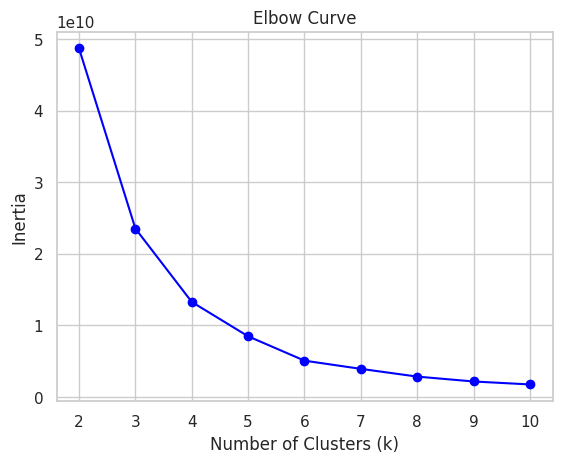

In [171]:
# Determine the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(data, kmeans.labels_))

# Plot the elbow curve
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [172]:
# Perform GridSearch to find the best model with optimal parameters
param_grid = {'n_clusters': k_values}
kmeans_grid = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans_grid, param_grid, scoring='neg_mean_squared_error')
grid_search.fit(df1_encoded)
best_k = grid_search.best_params_['n_clusters']
best_kmeans = grid_search.best_estimator_

# Fit the data to the best KMeans model
best_kmeans.fit(df1_encoded)

# Evaluate the model's performance
labels = best_kmeans.labels_
silhouette_avg = silhouette_score(df1_encoded, labels)
davies_bouldin_avg = davies_bouldin_score(df1_encoded, labels)

# Print the silhouette score and Davies-Bouldin index
print('Silhouette Score:', silhouette_avg)
print('Davies-Bouldin Index:', davies_bouldin_avg)

Silhouette Score: 0.5622645104952335
Davies-Bouldin Index: 0.5847982967060421


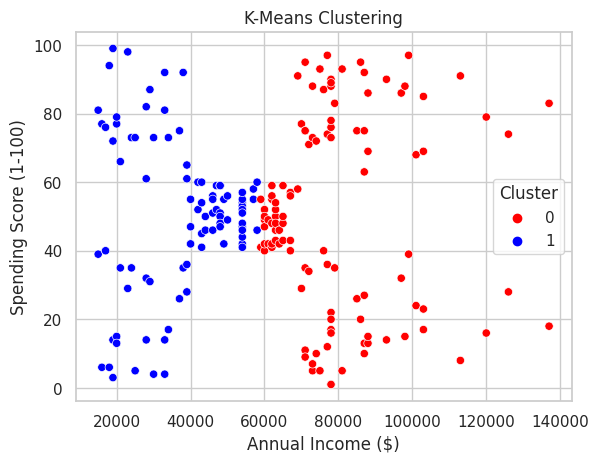

In [173]:
# Visualize the cluster assignments
df1_encoded['Cluster'] = labels
sns.scatterplot(data=df1_encoded, x='Annual Income ($)', y='Spending Score (1-100)', hue='Cluster')
plt.title('K-Means Clustering')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.show()

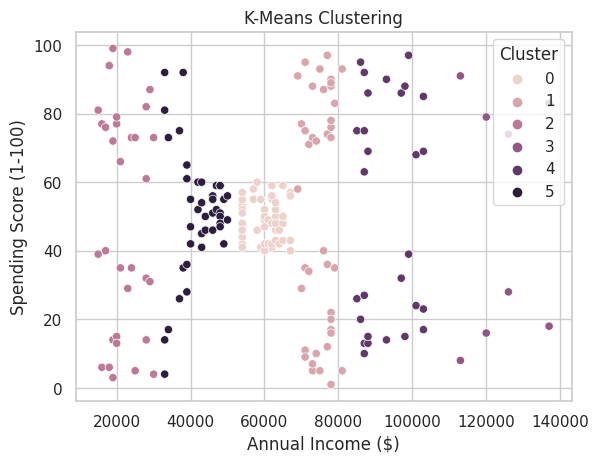

In [174]:
from sklearn.cluster import KMeans

# Select the features for clustering
features = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']

# Extract the feature data for clustering
X = df1_encoded[features].values

# Define the desired number of clusters
n_clusters = 6

# Apply KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(X)

# Retrieve the cluster labels
labels = kmeans.labels_

# Visualize the cluster assignments
df1_encoded['Cluster'] = labels
sns.scatterplot(data=df1_encoded, x='Annual Income ($)', y='Spending Score (1-100)', hue='Cluster')
plt.title('K-Means Clustering')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.show()


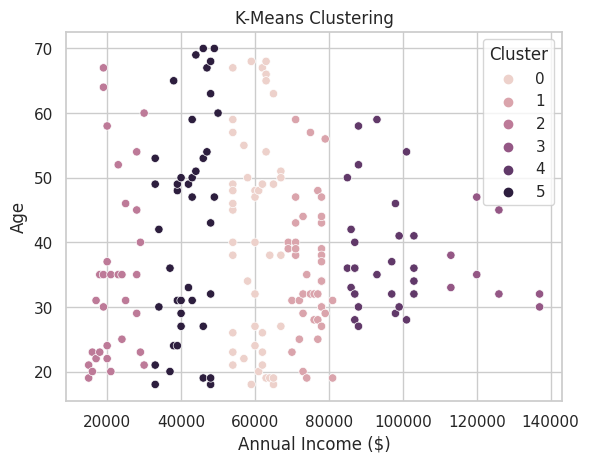

In [175]:
# Visualize the cluster assignments
df1_encoded['Cluster'] = labels
sns.scatterplot(data=df1_encoded, x='Annual Income ($)', y='Age', hue='Cluster')
plt.title('K-Means Clustering')
plt.xlabel('Annual Income ($)')
plt.ylabel('Age')
plt.show()

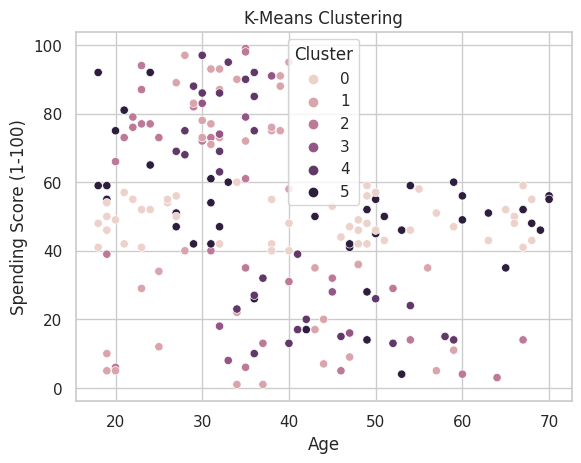

In [176]:
# Visualize the cluster assignments
df1_encoded['Cluster'] = labels
sns.scatterplot(data=df1_encoded, x='Age', y='Spending Score (1-100)', hue='Cluster')
plt.title('K-Means Clustering')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

## In Conlusion

I am ending this project in this note, I was able to find some clusters in the data, but I don't think it is valuable to a firm